# Preprocessing of Lorenz attractor data

**Author:** M.G. Baltussen

**Estimated running time:** 1 minute

**Generated output:**
```
data/lorenz.csv
plots_extended/lorenz_traces.{svg,png}
```

In [1]:
""" System imports """

import pathlib
import toml

""" Essential imports"""
import numpy as np
import pandas as pd

""" ML/RC imports """
from sklearn.feature_selection import mutual_info_regression as mi_reg
from sklearn import linear_model, model_selection, preprocessing, svm
from sklearn import metrics

from pyrcn.echo_state_network import ESNClassifier


""" Visualization imports and settings"""
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import seaborn as sns

sns.set_theme(
    style="ticks",
    context="paper",
    font_scale=0.75,
    rc={
        "axes.linewidth": 0.5,
        "axes.facecolor": "#eceff4",
        "axes.edgecolor": "#2e3440",
        "axes.labelcolor": "#2e3440",
        "text.color": "#2e3440",
        "xtick.color": "#2e3440",
        "ytick.color": "#2e3440",
        "font.family": "Arial",
        "svg.fonttype": "none",
    },
)
import colorcet as cc

nord_palette = [
    "#bf616a",
    "#d08770",
    "#ebcb8b",
    "#a3be8c",
    "#b48ead",
    "#8fbcbb",
    "#88c0d0",
    "#81a1c1",
    "#5e81ac",
    "#2e3440",
    "#3b4252",
    "#434c5e",
    "#4c566a",
    "#d8dee9",
    "#e5e9f0",
    "#eceff4",
]

sns.set_palette(nord_palette)


def save_plot(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots/{name}.svg", **kwargs)
    plt.savefig(f"../plots/{name}.png", dpi=600, **kwargs)


def save_si(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots_extended/{name}.svg", **kwargs)
    plt.savefig(f"../plots_extended/{name}.png", dpi=600, **kwargs)

In [2]:
""" Load input flows and remove initial steady-state """

flowrate = 435 / (2 * 60)  # ul/s

inputs = pd.read_excel(
    "../data/lorenz_input.xlsx",
    usecols=[0, 1, 2, 3, 4],
    names=["time", "DHA", "NaOH", "CaCl2", "formaldehyde"],
).query("time >= 3600")
inputs = inputs.assign(time=(inputs.time - 3600).round(0))

In [3]:
""" Load ion signals, align with input and bin into 10s timeblocks"""

OFFSET_DATA = 3900

files = pathlib.Path("../data/lorenz/").glob("*.dat")
df = pd.concat(
    (pd.read_csv(f, sep="\t").assign(species=f.stem) for f in files), ignore_index=True
)
df = df.assign(retention_time=df.retention_time.round(1)).rename(
    columns={"retention_time": "time"}
)
df = df.pivot(index=["time"], columns="species", values="intensity")
df = df.reset_index()

bins = np.arange(5, df.time.max() + 5, 10, dtype=int)
df = df.assign(time=pd.cut(df.time, bins=bins, labels=bins[1:] - 5, right=True))
df = df.groupby("time").mean().reset_index()
df = (
    df.assign(time=df.time.astype(int) - OFFSET_DATA)
    .set_index("time")
    .query("0 <= time <= 35000")
)

df_inputs = inputs.query("0 < time < 30000").set_index("time", drop=True)
df_inputs.index = df_inputs.index.astype("int64")
df_data = (
    df.assign(time=df.index - 110)
    .query("0 < time < 30000")
    .fillna(0)
    .set_index("time", drop=True)
)

df_inputs = df_inputs.loc[df_data.index]
df_data = df_data.loc[df_data.index.intersection(df_inputs.index)].fillna(0)

df_all = pd.concat([df_inputs, df_data], axis=1)
df_all.to_csv("../data/lorenz.csv", index=True)

/tmp/ipykernel_15332/4166931892.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby("time").mean().reset_index()


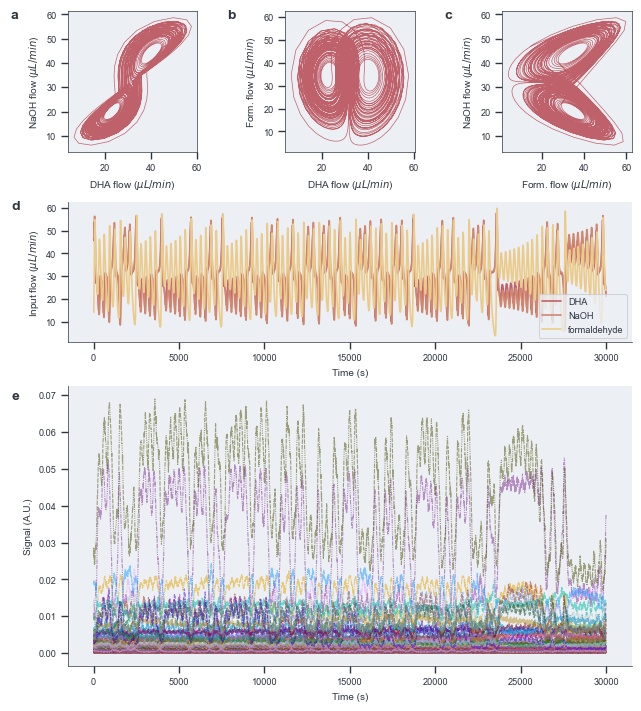

In [4]:
""" Plot flow inputs together with observed ion signals"""

fig = plt.figure(constrained_layout=True, figsize=(6.3, 7.0))
gs = fig.add_gridspec(ncols=3, nrows=4)
axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1, :]),
]
df_inputs.plot(ax=axes[0], x="DHA", y="NaOH", legend=None, lw=0.5)
df_inputs.plot(ax=axes[1], x="DHA", y="formaldehyde", legend=None, lw=0.5)
df_inputs.plot(ax=axes[2], x="formaldehyde", y="NaOH", legend=None, lw=0.5)
df_inputs.plot(ax=axes[3], y=["DHA", "NaOH", "formaldehyde"])

ax = fig.add_subplot(gs[2:, :])
sns.lineplot(
    ax=ax,
    data=df_data,
    legend=None,
    lw=0.8,
    alpha=0.5,
    palette=cc.glasbey_dark[: df.shape[1]],
)

axes[0].set_xlabel("DHA flow ($\mu L/min$)")
axes[1].set_xlabel("DHA flow ($\mu L/min$)")
axes[2].set_xlabel("Form. flow ($\mu L/min$)")
axes[0].set_ylabel("NaOH flow ($\mu L/min$)")
axes[1].set_ylabel("Form. flow ($\mu L/min$)")
axes[2].set_ylabel("NaOH flow ($\mu L/min$)")

axes[0].text(-0.45, 0.95, "a", transform=axes[0].transAxes, size=10, weight="bold")
axes[1].text(-0.45, 0.95, "b", transform=axes[1].transAxes, size=10, weight="bold")
axes[2].text(-0.45, 0.95, "c", transform=axes[2].transAxes, size=10, weight="bold")
axes[3].text(-0.1, 0.95, "d", transform=axes[3].transAxes, size=10, weight="bold")
ax.text(-0.1, 0.95, "e", transform=ax.transAxes, size=10, weight="bold")

axes[-1].set_xlabel("Time (s)")
axes[-1].set_ylabel(r"Input flow ($\mu L/min$)")
ax.set_ylabel("Signal (A.U.)")
ax.set_xlabel("Time (s)")

sns.despine(ax=ax)
sns.despine(ax=axes[3])
save_si("lorenz_traces")
plt.show()